In [1]:
import geopandas as gpd
import os
import xarray as xr
import numpy as np
import pandas as pd
import copy
import pickle
import gc
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt


In [2]:
data_dir = '/mnt/CEPH_PROJECTS/sao/openEO_Platform'

In [3]:
big_pv_geoms = gpd.read_file(f"{data_dir}/germany_photovoltaic.shp")

In [4]:
# Filter the data to have farms bigger then 5 km2
big_pv_geoms_32632 = big_pv_geoms.to_crs(32632)
big_pv_geoms_32632_buffer_20 = copy.deepcopy(big_pv_geoms_32632)
big_pv_geoms_32632_buffer_20["geometry"] = [i.buffer(20) for i in big_pv_geoms_32632_buffer_20.geometry]
big_pv_geoms_buffer = big_pv_geoms_32632_buffer_20.to_crs(4326)


print(f"Number of selected PV Farms: {len(big_pv_geoms_buffer)}")

Number of selected PV Farms: 4458


In [5]:
bands = ['B01','B02','B03','B04',
         'B05','B06','B07','B08',
         'B8A', 'B11', 'B12']

### Extract the data and save them as numpy arrays
Run this section just for the first time

In [5]:
for i, geom in big_pv_geoms_buffer.iterrows():
    try:
        data = xr.open_dataset(f"{data_dir}/s2/germany/s2_2022_{i}.nc",decode_coords="all")
        
        ## This step to fill the gaps (nan values) spatially
        data = data.groupby('t').apply(lambda x: x.fillna(x.mean(dim=('x','y'))))
        #data_filled['crs'] = data.crs
        data.rio.write_crs("epsg:32633", inplace=True) #32633

        ## Filter clouds pixels
        cloud_mask = np.bitwise_or((data.SCL == 8),(data.SCL == 9))
        geodf = gpd.GeoDataFrame(geometry=[geom["geometry"]],crs="EPSG:32632")
        data = data.where(~cloud_mask)

        ## Clip the farm polygon
        clipped = data.rio.clip(geodf.geometry.values, geodf.crs, drop=False, invert=False)
        break        
    except:
         print(f"This polygon id: {i} is not exist.")

This polygon id: 0 is not exist.
This polygon id: 1 is not exist.


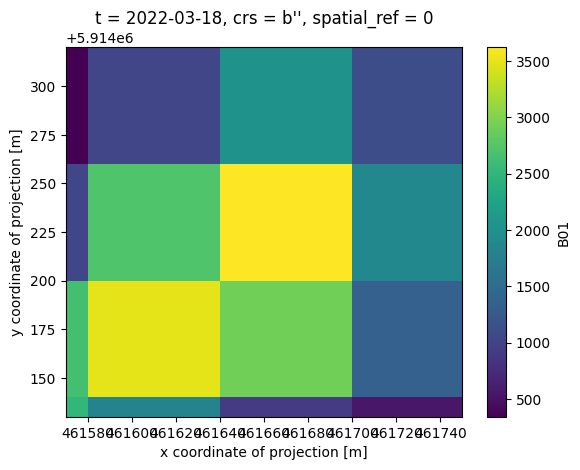

In [6]:
data['B01'][30].plot()

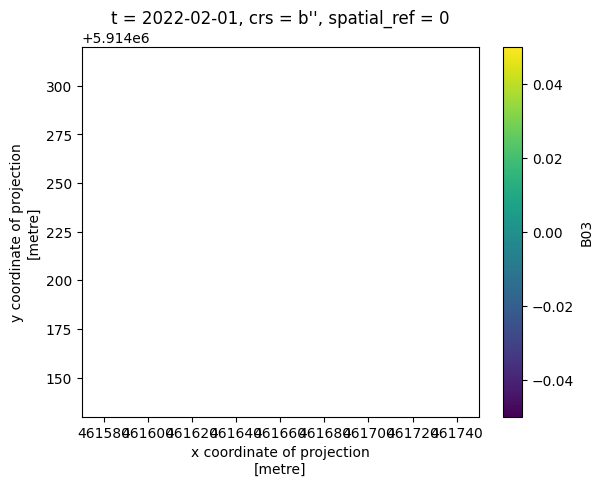

In [8]:
clipped['B03'][12].plot()

In [ ]:
# Extract S2 data for the photvoltaic farms - pixels inside the polygons "labels as 1"

start_date = '2022-01-01'
end_date = '2022-12-31'

all_pixels_ts = []
for i, geom in big_pv_geoms_32632[280:].iterrows():
    try:
        data = xr.open_dataset(f"{data_dir}/s2/germany/s2_2022_{i}.nc",decode_coords="all")
              
        ## Filter clouds pixels
        cloud_mask = np.bitwise_or((data.SCL == 8),(data.SCL == 9))
        geodf = gpd.GeoDataFrame(geometry=[geom["geometry"]],crs="EPSG:32632")
        data = data.where(~cloud_mask)  

        ## This step to fill the gaps (nan values) spatially
        data = data.groupby('t').apply(lambda x: x.fillna(x.mean(dim=('x','y'))))
        data.rio.write_crs("epsg:32633", inplace=True) #32633


        ## Linear interpolation to have full time-series
        daily_date_range = pd.date_range(start=pd.to_datetime(start_date), 
                                         end=pd.to_datetime(end_date),
                                         freq='D')

        ds_daily = data.reindex(t=daily_date_range)
        ds_daily_interp = ds_daily.interpolate_na(dim='t', method='linear')

        ## Clip the farm polygon
        clipped = ds_daily_interp.rio.clip(geodf.geometry.values, geodf.crs, drop=False, invert=False)

        df = clipped.to_dataframe().unstack(level='t')

        arr_ts= []
        for b in bands:
            df_b = df[b]
            df_b = df_b.dropna(how = 'all')
            arr_ts.append(np.array(df_b))

        all_pixels_ts.append(np.stack(arr_ts, axis=1))   
    
    except:
        print(f"This polygon id: {i} is not exist.")

This polygon id: 280 is not exist.
This polygon id: 282 is not exist.
This polygon id: 284 is not exist.
This polygon id: 287 is not exist.
This polygon id: 288 is not exist.
This polygon id: 294 is not exist.
This polygon id: 307 is not exist.
This polygon id: 308 is not exist.
This polygon id: 315 is not exist.
This polygon id: 328 is not exist.
This polygon id: 342 is not exist.
This polygon id: 344 is not exist.
This polygon id: 348 is not exist.
This polygon id: 350 is not exist.
This polygon id: 351 is not exist.
This polygon id: 353 is not exist.
This polygon id: 356 is not exist.
This polygon id: 365 is not exist.
This polygon id: 375 is not exist.
This polygon id: 376 is not exist.
This polygon id: 377 is not exist.
This polygon id: 386 is not exist.
This polygon id: 390 is not exist.
This polygon id: 400 is not exist.
This polygon id: 403 is not exist.
This polygon id: 414 is not exist.
This polygon id: 422 is not exist.
This polygon id: 424 is not exist.
This polygon id: 425

In [ ]:
pv_samples = np.vstack(all_pixels_ts)
pv_samples.shape

In [ ]:
y1 = np.ones(pv_samples.shape[0])

In [24]:
print(pv_samples.shape)
print(y1.shape)

(490597, 11, 365)
(490597,)


In [25]:
np.save(f'{data_dir}/s2/germany/extracted_non_temporal/pv_samples.npy', pv_samples)

In [9]:
# Extract S2 data for the photvoltaic farms - pixels outside the polygons "labels as 0"

start_date = '2022-01-01'
end_date = '2022-12-31'

all_pixels_ts = []
for i, geom in big_pv_geoms_32632[280:1500].iterrows():
    try:
        data = xr.open_dataset(f"{data_dir}/s2/germany/s2_2022_{i}.nc",decode_coords="all")

        ## Filter clouds pixels
        cloud_mask = np.bitwise_or((data.SCL == 8),(data.SCL == 9))
        geodf = gpd.GeoDataFrame(geometry=[geom["geometry"]],crs="EPSG:32632")
        data = data.where(~cloud_mask)  

        ## This step to fill the gaps (nan values) spatially
        data = data.groupby('t').apply(lambda x: x.fillna(x.mean(dim=('x','y'))))
        data.rio.write_crs("epsg:32633", inplace=True) #32633

        ## Linear interpolation to have full time-series
        daily_date_range = pd.date_range(start=pd.to_datetime(start_date), 
                                         end=pd.to_datetime(end_date),
                                         freq='D')

        ds_daily = data.reindex(t=daily_date_range)
        ds_daily_interp = ds_daily.interpolate_na(dim='t', method='linear')

        ## Clip the farm polygon
        clipped = ds_daily_interp.rio.clip(geodf.geometry.values, geodf.crs, drop=False, invert=True)

        df = clipped.to_dataframe().unstack(level='t')

        arr_ts= []
        for b in bands:
            df_b = df[b]
            df_b = df_b.dropna(how = 'all')
            arr_ts.append(np.array(df_b))

        all_pixels_ts.append(np.stack(arr_ts, axis=1))   
    except:
        print(f"This polygon id: {i} is not exist.")

This polygon id: 280 is not exist.
This polygon id: 282 is not exist.
This polygon id: 284 is not exist.
This polygon id: 287 is not exist.
This polygon id: 288 is not exist.
This polygon id: 294 is not exist.
This polygon id: 307 is not exist.
This polygon id: 308 is not exist.
This polygon id: 315 is not exist.
This polygon id: 328 is not exist.
This polygon id: 342 is not exist.
This polygon id: 344 is not exist.
This polygon id: 348 is not exist.
This polygon id: 350 is not exist.
This polygon id: 351 is not exist.
This polygon id: 353 is not exist.
This polygon id: 356 is not exist.
This polygon id: 365 is not exist.
This polygon id: 375 is not exist.
This polygon id: 376 is not exist.
This polygon id: 377 is not exist.
This polygon id: 386 is not exist.
This polygon id: 390 is not exist.
This polygon id: 400 is not exist.
This polygon id: 403 is not exist.
This polygon id: 414 is not exist.
This polygon id: 422 is not exist.
This polygon id: 424 is not exist.
This polygon id: 425

In [ ]:
non_pv_samples = np.vstack(all_pixels_ts)
non_pv_samples.shape

In [ ]:
y0 = np.zeros(non_pv_samples.shape[0])

In [ ]:
np.save(f'{data_dir}/s2/germany/extracted_non_temporal/non_pv_samples.npy', non_pv_samples)

#### Combine both PV and Non-PV togehter 

In [10]:
non_pv_samples = np.load(f'{data_dir}/s2/germany/extracted_non_temporal/non_pv_samples.npy')
pv_samples = np.load(f'{data_dir}/s2/germany/extracted_non_temporal/pv_samples.npy')

In [11]:
y1 = np.zeros(pv_samples.shape[0])
y0 = np.zeros(non_pv_samples.shape[0])

In [12]:
print(pv_samples.shape)
print(non_pv_samples.shape)

print(y1.shape)
print(y0.shape)

(490597, 11, 365)
(320803, 11, 365)
(490597,)
(320803,)


In [13]:
tr_data = np.vstack([pv_samples, non_pv_samples])
y = np.hstack([y1, y0])

In [14]:
print(tr_data.shape)
print(y.shape)

(498597, 11, 365)
(498597,)


### Modeling

In [6]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier

In [7]:
non_pv_samples = np.load(f'{data_dir}/s2/germany/extracted_non_temporal/non_pv_samples.npy')
pv_samples = np.load(f'{data_dir}/s2/germany/extracted_non_temporal/pv_samples.npy')

y1 = np.ones(pv_samples.shape[0])
y0 = np.zeros(non_pv_samples.shape[0])

tr_data = np.vstack([pv_samples, non_pv_samples])
y = np.hstack([y1, y0])

In [8]:
del non_pv_samples, pv_samples, y1, y0 ; gc.collect()

22

In [9]:
tr_data = np.nan_to_num(tr_data, nan=-999999)


KeyboardInterrupt



In [ ]:
tr_data = tr_data.reshape(tr_data.shape[0], tr_data.shape[1]*tr_data.shape[2])
tr_data.shape

In [11]:
skf = StratifiedKFold(n_splits=5,shuffle=True, random_state=2024) # for cross validation

# Creating loop for the stratified k fold
scores = []
i = 0
for train, val in skf.split(tr_data, y):
    print(f'########### Fold number {i+1} ')

    # spliting the data
    x_train, x_val = tr_data[train], tr_data[val]
    y_train, y_val = y[train], y[val]
    
    clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=2024)
    clf.fit(x_train, y_train)
    
    
    # Validation
    y_pred = clf.predict(x_val)
    score = accuracy_score(y_pred, y_val)
    scores.append(score)
    print(f'Accuracy Score: {score}')
    
    filename = f'../models/non_temporal_models/rf_non_temporal_{i+1}.sav'
    pickle.dump(clf, open(filename, 'wb'))
    
    i+=1
    break
print(f'Average F1 Score: {np.mean(scores)}')

########### Fold number 1 
Accuracy Score: 1.0
Average F1 Score: 1.0


In [ ]:
del tr_data, x_train, x_val, y_train, y_val; gc.collect()

### Inference  

#### Extrac the dataset 
Run it for the first time

In [57]:
# Extract S2 data for the photvoltaic farms - pixels inside the polygons "labels as 1"

start_date = '2022-01-01'
end_date = '2022-12-31'

all_pixels_ts = []
for i, geom in big_pv_geoms_32632[3:4].iterrows(): #280
    try:
        data = xr.open_dataset(f"{data_dir}/s2/germany/s2_2022_{i}.nc",decode_coords="all")
              
        ## Filter clouds pixels
        cloud_mask = np.bitwise_or((data.SCL == 8),(data.SCL == 9))
        geodf = gpd.GeoDataFrame(geometry=[geom["geometry"]],crs="EPSG:32632")
        data = data.where(~cloud_mask)  

        ## This step to fill the gaps (nan values) spatially
        data = data.groupby('t').apply(lambda x: x.fillna(x.mean(dim=('x','y'))))
        data.rio.write_crs("epsg:32633", inplace=True) #32633


        ## Linear interpolation to have full time-series
        daily_date_range = pd.date_range(start=pd.to_datetime(start_date), 
                                         end=pd.to_datetime(end_date),
                                         freq='D')

        ds_daily = data.reindex(t=daily_date_range)
        ds_daily_interp = ds_daily.interpolate_na(dim='t', method='linear')


        df = ds_daily_interp.to_dataframe().unstack(level='t')

        arr_ts= []
        for b in bands:
            df_b = df[b]
            df_b = df_b.dropna(how = 'all')
            arr_ts.append(np.array(df_b))

        all_pixels_ts.append(np.stack(arr_ts, axis=1)) 
        break
    
    except:
        print(f"This polygon id: {i} is not exist.")


In [46]:
te_samples = np.vstack(all_pixels_ts)
te_samples = np.nan_to_num(te_samples, nan=-999999)

In [47]:
#np.save(f'{data_dir}/s2/germany/extracted_non_temporal/te_samples.npy', te_samples)

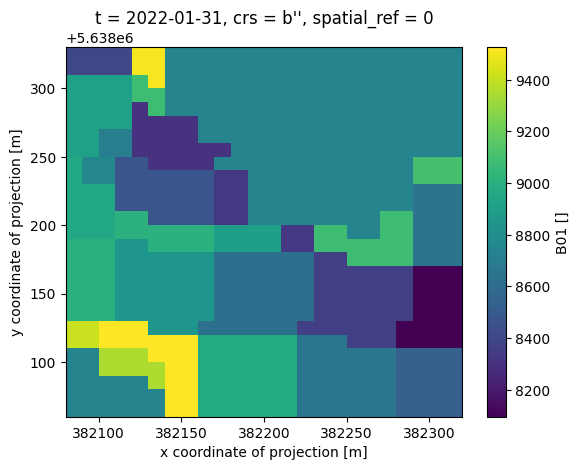

In [48]:
ds_daily_interp['B01'][30].plot()

In [49]:
## Clip the farm polygon - We do not crop it here cuz we need to classifiy all the pixels 
clipped = ds_daily_interp.rio.clip(geodf.geometry.values, geodf.crs, drop=False, invert=False)

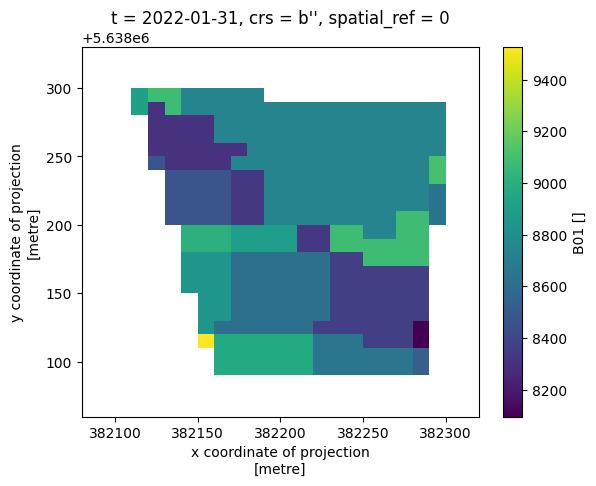

In [50]:
clipped['B01'][30].plot()

#### Inference

In [ ]:
te_samples = np.load(f'{data_dir}/s2/germany/extracted_non_temporal/te_samples.npy')

In [51]:
te_samples = te_samples.reshape(te_samples.shape[0], te_samples.shape[1]*te_samples.shape[2])
te_samples.shape

(648, 4015)

In [52]:
clf = pickle.load(open(f'../models/non_temporal_models/rf_non_temporal_1.sav', 'rb'))

In [53]:
te_pred = clf.predict(te_samples)

In [54]:
df_normal = df.reset_index()
x = df_normal[['x', 'y']].values[:,0]
y = df_normal[['x', 'y']].values[:,1]

In [55]:
te_pred

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

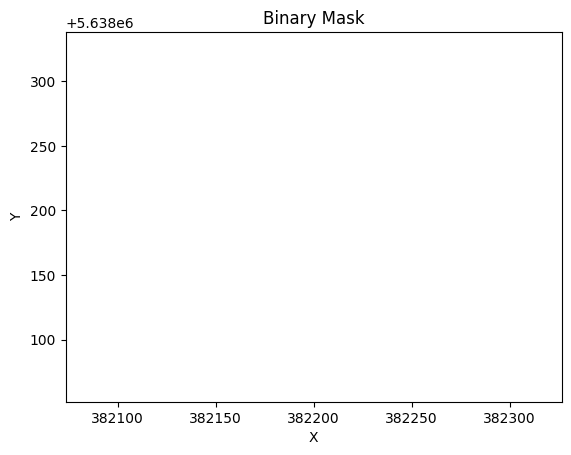

In [56]:
custom_cmap = ListedColormap(['white', 'yellow']) #yellow for 1 and white for 0

# Plot the binary mask
plt.scatter(x, y, c=te_pred, cmap=custom_cmap, s=500)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Binary Mask')
plt.show()